In [26]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os
import numpy as np
from align.align_trans import (
    get_reference_facial_points,
    warp_and_crop_face,
)
from align.detector import detect_faces
from PIL import Image
from tqdm import tqdm
import numpy as np
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, Dropout, Convolution2D, GlobalAveragePooling2D
from keras.models import Sequential
import tensorflow as tf
import tensorflow.keras.applications.mobilenet
import os
import PIL
import cv2
import keras
import matplotlib.pyplot as plt
from keras import layers
from keras import Model
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
def preprocess(IMG_SAVE_PATH):
    dataset = []
    for directory in os.listdir(IMG_SAVE_PATH):
        path = os.path.join(IMG_SAVE_PATH, directory)
        for image in os.listdir(path):
            new_path = os.path.join(path, image)
            try:
                imgpath=PIL.Image.open(new_path)
                imgpath=imgpath.convert('RGB')
                img = np.asarray(imgpath)
                img = cv2.resize(img, (224,224))
                img=img/255.
                dataset.append([img, directory])
            except FileNotFoundError:
                print('Image file not found. Skipping...')
    return dataset
def extract_frames(video_path, num_frames=30):
    cap = cv2.VideoCapture(video_path)
    frames = []
    count = 0
    while cap.isOpened() and count < num_frames:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (224, 224))  # Resize to 224x224
        frames.append(frame)
        count += 1
    
    cap.release()
    return np.array(frames)

def facedetection(imgname,filename):
    
    crop_size = 112
    scale = crop_size / 112.0
    reference = get_reference_facial_points(default_square=True) * scale
    img = Image.open(imgname)
    try: 
                    _, landmarks = detect_faces(img)
                    facial5points = [[landmarks[0][j], landmarks[0][j + 5]] for j in range(5)]
                    warped_face = warp_and_crop_face(
                        np.array(img),
                        facial5points,
                        reference,
                        crop_size=(crop_size, crop_size),
                    )
                    img_warped = Image.fromarray(warped_face)
                    
                    img_warped.save(filename)
    except Exception:
                    print(
                        "{} is discarded due to exception!".format(
                          Exception),
                        )
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,GRU, Activation, BatchNormalization, GlobalAveragePooling2D, Dropout, Concatenate, Input
from tensorflow.keras.models import Model

# Base model (MobileNetV2) definition
def create_combined_model(num_classes=2,  mobile_input_shape=(224, 224, 3)):
    input_tensor = Input(shape=(224, 224, 3))
    
    # Pretrained MobileNetV2 (without top layers)
    base_model = tf.keras.applications.MobileNetV2(include_top=False,
                                                         weights='imagenet',
                                                         input_shape=mobile_input_shape)
    base_model.trainable = False  # Freeze MobileNetV2 layers
    
    # Flatten the output of the base model (MobileNetV2)
    inception_output = Flatten()(base_model.output)
    
    
    x = tf.keras.layers.Reshape((1, -1))(inception_output)
    x = GRU(128, return_sequences=True)(x)
    x = Flatten()(x)
    
    # Add dense layers after concatenation
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    
    # Output layer (adjust the output for the number of classes)
    output = Dense(num_classes, activation='softmax')(x)
    
    # Create the final model
    model = Model(inputs=[base_model.input], outputs=output)
    
    return model

# Instantiate the model
model = create_combined_model(num_classes=2)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the combined model
model.summary()
model.load_weights('DeepFake.h5')
     

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [27]:
count=0
video_path="dataset/fake/id0_id1_0000.mp4"
video_frames = extract_frames(video_path)
for frame in video_frames:
        count=count+1
        filepath="Test/frame/"+str(count)+".jpg"
        cv2.imwrite("1.jpg", frame)
        facedetection("1.jpg",filepath)

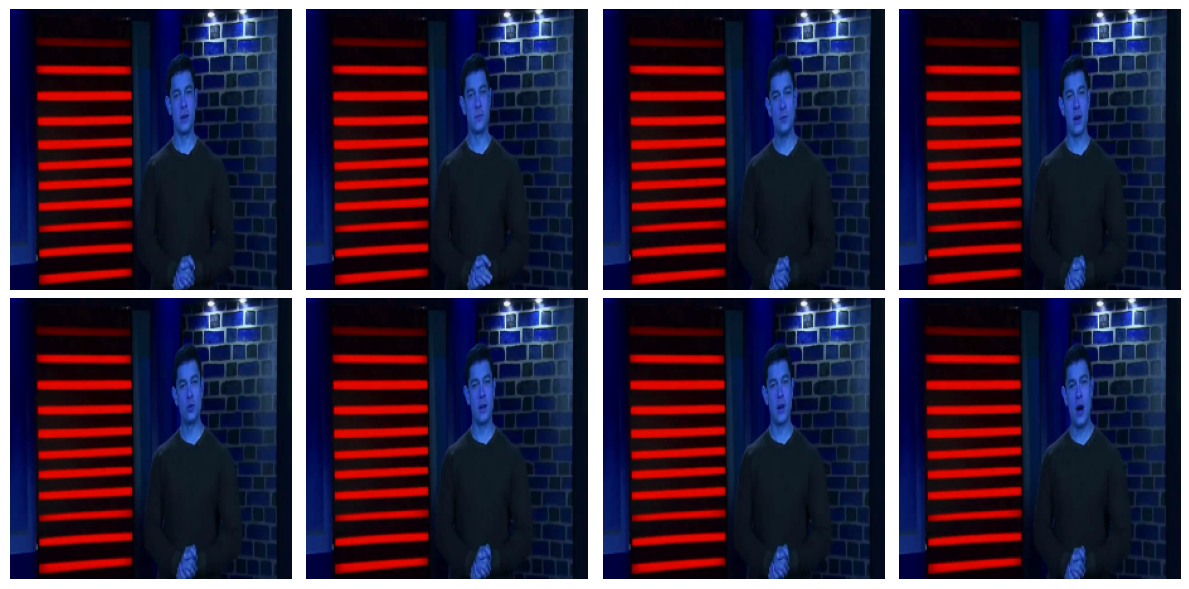

In [32]:
import matplotlib.pyplot as plt
import random

# Randomly select 8 indices from the dataset
indices = random.sample(range(len(video_frames)), 8)

# Set up the plot grid
plt.figure(figsize=(12, 6))

# Loop through the selected indices
for i, idx in enumerate(indices):
    plt.subplot(2, 4, i + 1)  # 2 rows, 4 columns
    plt.imshow(video_frames[idx])  # Assuming data[idx] is an image
   
    plt.axis('off')

# Display the plot
plt.tight_layout()
plt.show()

In [28]:
traindata=preprocess("Test")

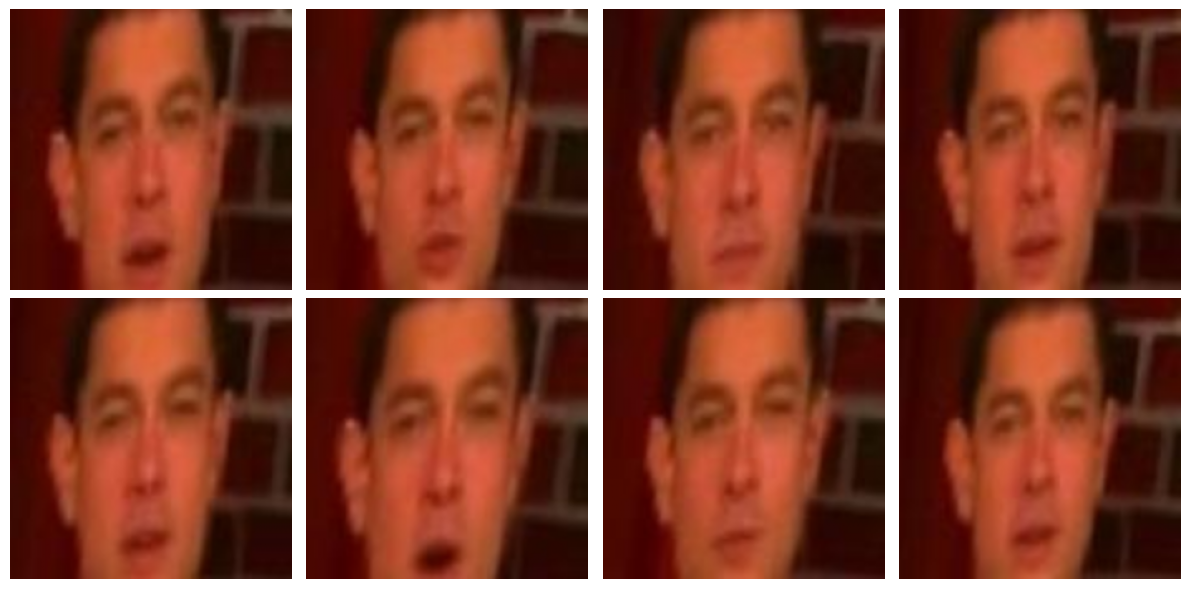

In [29]:
xtest, labelstest = zip(*traindata)

import matplotlib.pyplot as plt
import random

# Randomly select 8 indices from the dataset
indices = random.sample(range(len(xtest)), 8)

# Set up the plot grid
plt.figure(figsize=(12, 6))

# Loop through the selected indices
for i, idx in enumerate(indices):
    plt.subplot(2, 4, i + 1)  # 2 rows, 4 columns
    plt.imshow(xtest[idx])  # Assuming data[idx] is an image
   
    plt.axis('off')

# Display the plot
plt.tight_layout()
plt.show()

In [30]:
xtest=np.array(xtest)
Y_pred = model.predict(xtest)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

In [31]:
Y_pred_classes=Y_pred_classes.tolist()
count_zeros = Y_pred_classes.count(0)
count_ones = Y_pred_classes.count(1)
if(count_zeros>count_ones):
    print("Fake Video")
else:
    print("Real video")

Fake Video
